# Decomposition Example

First step, set the paths to where to find the motif dictionary and associated code. Note that these are available at http://github.com/sdrogers/motifdb

In [1]:
motifdbcodepath = '/Users/simon/git/motifdb/code/utilities/'
motifdbpath = '/Users/simon/git/motifdb/motifs/'

Load some motifs from the motif database, I'm just loading the massbank ones

In [2]:
import sys
sys.path.append(motifdbcodepath)
from motifdb_loader import load_db
db_list = ['massbank_binned_005']
spectra,motif_metadata = load_db(db_list,motifdbpath)

Looking in /Users/simon/git/motifdb/motifs/massbank_binned_005/*.m2m
	 Found 61
Found total of 61 motif files


spectra is a dictionary with key the filename of the motif and values another dictionary with feature / probability pairs

In [3]:
import numpy as np

make an index of the unique features -- we can only decompose onto features that are loaded from the database

In [4]:
word_index = {}
word_pos = 0
for motif,word_probs in spectra.items():
    for word,probability in word_probs.items():
        if not word in word_index:
            word_index[word] = word_pos
            word_pos += 1

Put the words and motifs into a matrix ($\beta$)

In [11]:
# Create a beta matrix
motif_index = {}
motif_pos = 0
n_motifs = len(spectra)
n_words = len(word_index)
beta = np.zeros((n_motifs,n_words),np.double)
for motif,word_probs in spectra.items():
    motif_index[motif] = motif_pos
    for word,probability in word_probs.items():
        beta[motif_pos,word_index[word]] = probability
    motif_pos += 1

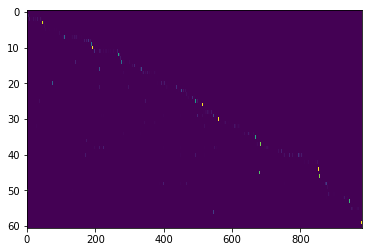

In [12]:
import pylab as plt
%matplotlib inline
plt.imshow(beta,aspect='auto')


Renomalise beta as when we save motifs we threshold on the probabilities and they end up not summing to 1

*Addition*: made sure there were no zeros

In [13]:
# find the minimum value of beta that isn't zero
pos = np.where(beta > 0)
min_val = beta[pos].min()
zpos = np.where(beta == 0)
beta[zpos] = min_val/100

In [14]:
beta /= beta.sum(axis=1)[:,None]

Load some data..I'm loading massbank data, but other datasets are available. Also assuming the motifs were made using binned features

In [15]:
ldacodepath = '/Users/simon/git/lda/code/'
sys.path.append(ldacodepath)
from ms2lda_feature_extraction import LoadGNPS,MakeBinnedFeatures

import glob
massbank_data = glob.glob('/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/fingerid-104-traindata/spectra_massbank/*.ms')
sub_data = massbank_data[:100]
l = LoadGNPS()
ms1,ms2,spectral_metadata = l.load_spectra(sub_data)
m = MakeBinnedFeatures()
corpus,word_mz_range = m.make_features(ms2)
corpus = corpus[corpus.keys()[0]]

Processed 100 spectra
100 documents
After removing empty words, 3695 words left


Do the decomposition

Some points to note here:
 - Features in the spectra that are not in the motifs don't add anything to they get skipped. I compute (`proportion_in`) the percentage of intensity that is usable.
 - This should be taken into account when interpreting the spectra-motif probabilities (`theta`). These values can be interpreted as the proportion of the usable part of the spectra, and not the total.
 - I also compute overlap score, as it's useful to see how much of the motif is in the spectrum

This is a handy function to compute the overlap score

In [24]:
def compute_overlap(phi_matrix,motif_pos,beta_row,word_index):
    overlap_score = 0.0
    for word in phi_matrix:
        if word in word_index:
            word_pos = word_index[word]
            if phi_matrix[word] == None:
                continue
            else:
                overlap_score += phi_matrix[word][motif_pos]*beta_row[word_pos]
    return overlap_score

 - This is the actual decomposition. 
 - The main loop goes over 100 times, this is probably overkill but it jumps out if the total absolute change in `gamma` is less than `1e-6`.
 - This code doesn't compute alpha, but I can add that if necessary
 - I get a warning about a `log(0)`. This is due to some entries in beta being 0, and it doesn't cause any problem, but could be removed by setting all the zero values to somethign very small and then re-normalising the beta matrix.
 - I do some plotting at the end to show how stuff can be exposed
 - If you wanted to see the decomposition at the individual feature level then you would need to keep hold of `phi_matrix` which gives (for each word), the probabilities over each motif.

In [ ]:
from scipy.special import psi as psi
theta = {}
K = n_motifs
alpha = 1 # will have some effect, but there's no way to set it. Making it low means we'll get sparse solutions
overlap_scores = {}
for doc in corpus:
    print doc
    # Compute the proportion of this docs intensity that is represented in the motifs
    total_in = 0.0
    total = 0.0
    doc_dict = corpus[doc]
    for word,intensity in doc_dict.items():
        total += intensity
        if word in word_index:
            total_in += intensity
    proportion_in = (1.0*total_in)/total
    print '\t',proportion_in
    if proportion_in > 0: # Be careful: if there is no overlap between the features in the spectrum and those across the motifs, bad things might happen
        phi_matrix = {}
        for word in doc_dict:
            phi_matrix[word] = None
        gamma = np.ones(K)
        for i in range(100):
            temp_gamma = np.zeros(K) + alpha
            for word,intensity in doc_dict.items():
                if word in word_index:
                    word_pos = word_index[word]
                    if beta[:,word_pos].sum()>0:
                        log_phi_matrix = np.log(beta[:,word_pos]) + psi(gamma)
                        log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                        phi_matrix[word] = log_phi_matrix/log_phi_matrix.sum()
                        temp_gamma += phi_matrix[word]*intensity
            gamma_change = np.sum(np.abs(gamma - temp_gamma))
            gamma = temp_gamma.copy()
            if gamma_change < 1e-6:
                break
        temp_theta = (gamma/gamma.sum()).flatten()
        theta[doc] = {}
        overlap_scores[doc] = {}
        for motif,motif_pos in motif_index.items():
            theta[doc][motif] = temp_theta[motif_pos]
            overlap_scores[doc][motif] = compute_overlap(phi_matrix,motif_pos,beta[motif_pos,:],word_index)

        # print some things!
        tm = zip(theta[doc].keys(),theta[doc].values())
        tm = sorted(tm,key = lambda x: x[1],reverse = True)
        for mo,th in tm[:3]:
            print '\t\t',mo,th,overlap_scores[doc][mo],motif_metadata[mo]['SHORT_ANNOTATION'][:40]



eawag_0110.ms
	0.238126656158
		mb_motif_144.m2m 0.510440464062 0.0655765771821 ClassyFire: hydroxytriazine substructure
		mb_motif_119.m2m 0.361434294668 0.0345710960213 ClassyFire: Chloro-s-triazine substructu
		mb_motif_146.m2m 0.0467081774823 0.00494023126411 Methylxanthine related loss
eawag_0062.ms
	0.170733848917
		mb_motif_4.m2m 0.569719349681 0.0208437925137 Loss of methyl group – indicative for 
		mb_motif_13.m2m 0.32890199216 0.157566614904 Alkyl aromatic substructure – indicati
		mb_motif_426.m2m 0.0735191395336 0.0157841524332 ClassyFire: di/trialkylated indole
eawag_0018.ms
	0.101952706187
		mb_motif_36.m2m 0.540014995772 0.0643120711917 Fragments indicative for asparagine subs
		mb_motif_3.m2m 0.349359642565 0.990284794339 Small nitrogen containing fragment ion �
		mb_motif_50.m2m 0.0621625928898 0.246859542233 ClassyFire: 1 3-dichlorobenzene
eawag_0012.ms
	0.0963777958481
		mb_motif_27.m2m 0.428075200692 0.990314757657 Loss indicative of carboxylic acid group
		mb_motif

/Users/simon/.virtualenvs/ms2ldaviz/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


Atenolol related fragments and losses
eawag_0094.ms
	0.424228224093
		mb_motif_22.m2m 0.988167458542 0.990321160556 Water loss - indicative of a free hydrox
		mb_motif_12.m2m 0.00662219580145 0.00915331753227 Leucine related fragments and losses
		mb_motif_262.m2m 0.00222548786799 0.00180821903126 ClassyFire: deoxypentose related loss
eawag_0109.ms
	0.36738373867
		mb_motif_30.m2m 0.870759886215 0.988906526518 Fragment indicative for aromatic compoun
		mb_motif_10.m2m 0.0868946110195 0.539105712771 Loss of C3H6 - indicative for the presen
		mb_motif_35.m2m 0.0130044400753 0.901010652405 Fragment ions indicative for alkylamine 
eawag_0044.ms
	0.146580234792
		mb_motif_7.m2m 0.446195457903 0.990295938998 Aliphatic alkylamine (in beer: NH3 loss 
		mb_motif_11.m2m 0.235347907381 0.00677031993497 Atenolol related fragments and losses
		mb_motif_28.m2m 0.18388318307 0.0375182431611 Fragment ions indicative for C6H12NO sub
eawag_0081.ms
	0.251472836866
		mb_motif_4.m2m 0.405921638847 0.776853